In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install catboost
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from scipy.stats import pearsonr



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


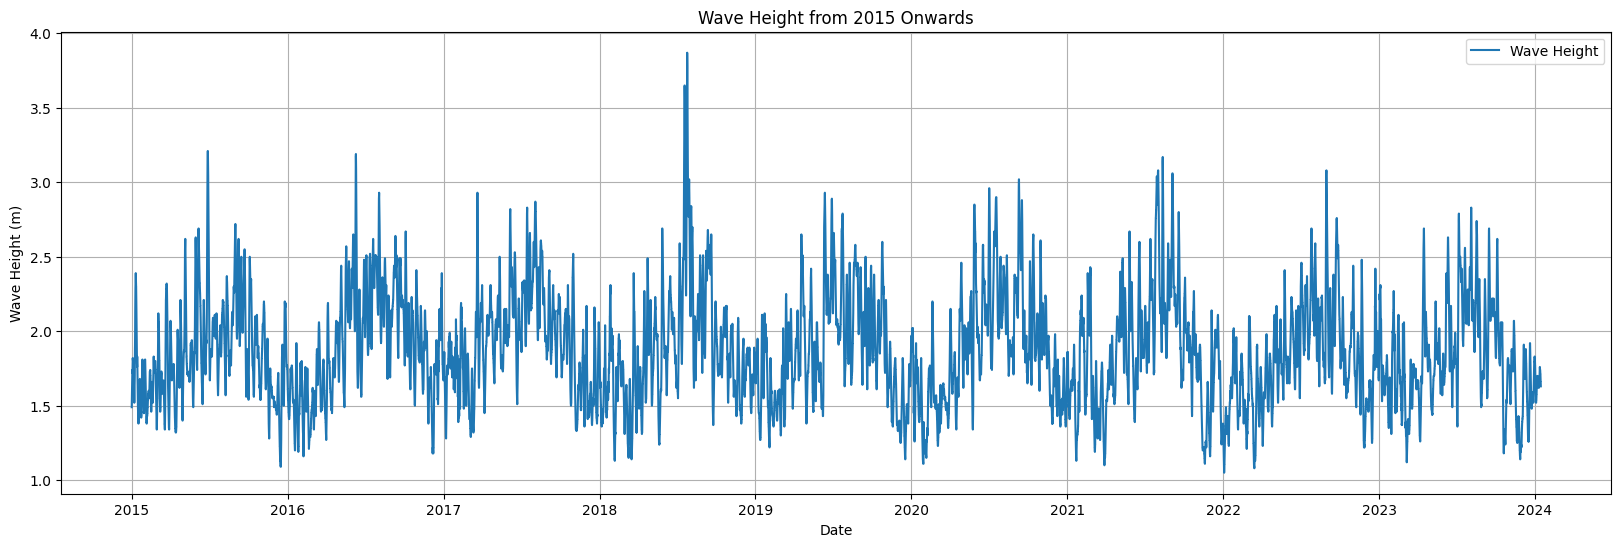

In [3]:

# Memuat dataset
data = pd.read_csv('TOTAL_WAVE_PC-C2_HsTpDir_formatted.csv', sep=';')

# Memfilter data mulai dari tahun 2015
data_filtered = data[data['Year'] >= 2015].drop(['Wave_Period', 'Wave_Direction'], axis=1)

# Konversi kolom waktu menjadi format datetime
data_filtered['Date'] = pd.to_datetime(data_filtered[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']])

# Set kolom Date sebagai index untuk keperluan plotting dan analisis time series
data_filtered.set_index('Date', inplace=True)

# Plot data Wave Height mulai dari tahun 2015
plt.figure(figsize=(20, 6))
plt.plot(data_filtered.index, data_filtered['Wave_Height'], label='Wave Height')
plt.title('Wave Height from 2015 Onwards')
plt.xlabel('Date')
plt.ylabel('Wave Height (m)')
plt.grid(True)
plt.legend()
plt.show()



In [4]:
# Fungsi untuk membuat lag features
def create_lag_features(data, lag=3):
    lagged_data = data.copy()
    for i in range(1, lag + 1):
        lagged_data[f'Wave_Height_lag_{i}'] = lagged_data['Wave_Height'].shift(i)
    return lagged_data

# Menambahkan lag 3
lag = 3
data_with_lags = create_lag_features(data_filtered, lag)

# Menghapus baris dengan nilai NaN (karena shift menyebabkan missing values di awal)
data_with_lags.dropna(inplace=True)

# Menampilkan data dengan fitur lag
print(data_with_lags.head())

                     Year  Month  Day  Hour  Minute  Second  Wave_Height  \
Date                                                                       
2015-01-01 04:30:00  2015    1.0  1.0   4.0    30.0     0.0         1.53   
2015-01-01 06:00:00  2015    1.0  1.0   6.0     0.0     0.0         1.54   
2015-01-01 07:30:00  2015    1.0  1.0   7.0    30.0     0.0         1.55   
2015-01-01 09:00:00  2015    1.0  1.0   9.0     0.0     0.0         1.57   
2015-01-01 10:30:00  2015    1.0  1.0  10.0    30.0     0.0         1.58   

                     Wave_Height_lag_1  Wave_Height_lag_2  Wave_Height_lag_3  
Date                                                                          
2015-01-01 04:30:00               1.51               1.50               1.49  
2015-01-01 06:00:00               1.53               1.51               1.50  
2015-01-01 07:30:00               1.54               1.53               1.51  
2015-01-01 09:00:00               1.55               1.54               

Missing values in original data (2015-2021):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in original target (2015-2021):
0
Missing values in training features (2022):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in training target (2022):
0
Missing values in testing features (2023-2024):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in testing target (2023-2024):
0


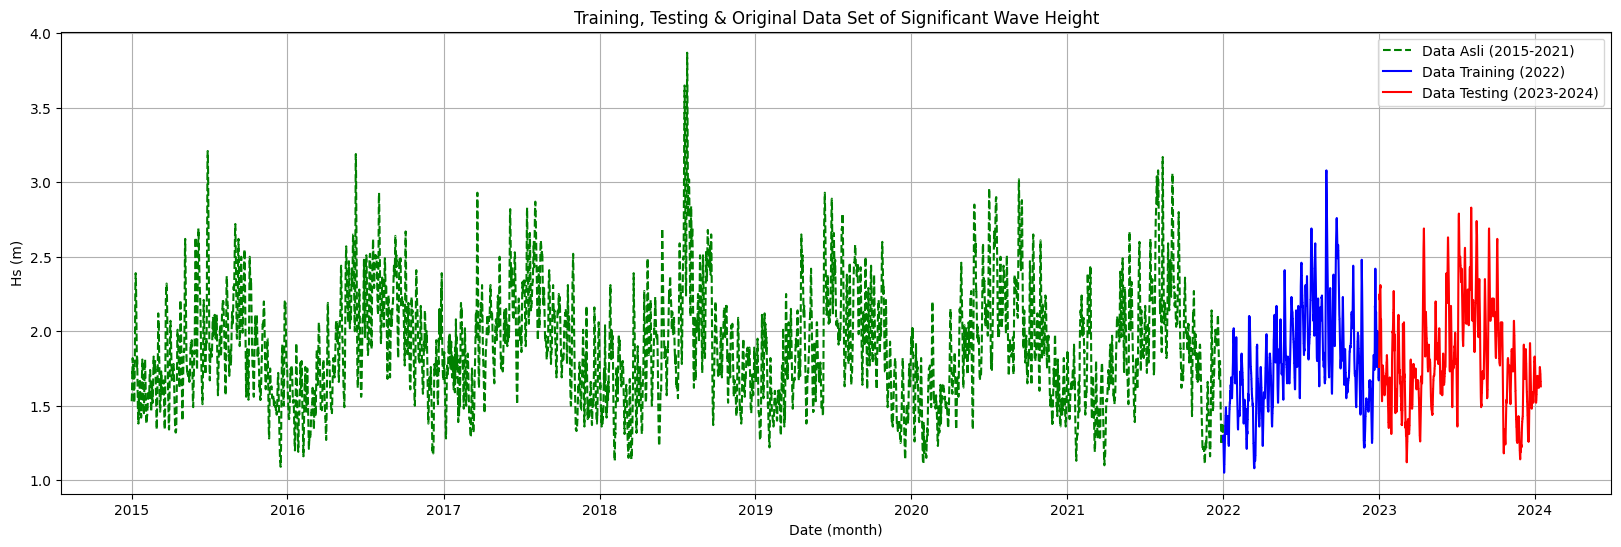

In [5]:
# Pastikan data terurut berdasarkan indeks waktu
data_with_lags = data_with_lags.sort_index()

# Membagi data berdasarkan rentang waktu
# Data asli 2015-2021
X_original = data_with_lags.loc['2015-01-01':'2021-12-31'].drop(columns=['Wave_Height'])
y_original = data_with_lags.loc['2015-01-01':'2021-12-31', 'Wave_Height']

# Data training 2022
X_train_lag_1_year = data_with_lags.loc['2022-01-01':'2022-12-31'].drop(columns=['Wave_Height'])
y_train_lag_1_year = data_with_lags.loc['2022-01-01':'2022-12-31', 'Wave_Height']

# Data testing 2023-2024
X_test_lag_1_year = data_with_lags.loc['2023-01-01':'2024-01-15'].drop(columns=['Wave_Height'])
y_test_lag_1_year = data_with_lags.loc['2023-01-01':'2024-01-15', 'Wave_Height']

# Cek apakah ada missing values di data asli, training, dan testing
print("Missing values in original data (2015-2021):")
print(X_original.isnull().sum())  # Untuk fitur asli
print("Missing values in original target (2015-2021):")
print(y_original.isnull().sum())  # Untuk target asli

print("Missing values in training features (2022):")
print(X_train_lag_1_year.isnull().sum())  # Untuk fitur training
print("Missing values in training target (2022):")
print(y_train_lag_1_year.isnull().sum())  # Untuk target training

print("Missing values in testing features (2023-2024):")
print(X_test_lag_1_year.isnull().sum())  # Untuk fitur testing
print("Missing values in testing target (2023-2024):")
print(y_test_lag_1_year.isnull().sum())  # Untuk target testing

# Jika ada missing values, kita interpolasi
X_original = X_original.interpolate(method='linear')
y_original = y_original.interpolate(method='linear')

X_train_lag_1_year = X_train_lag_1_year.interpolate(method='linear')
y_train_lag_1_year = y_train_lag_1_year.interpolate(method='linear')

X_test_lag_1_year = X_test_lag_1_year.interpolate(method='linear')
y_test_lag_1_year = y_test_lag_1_year.interpolate(method='linear')

# Plot data asli (2015-2021), training (2022), dan testing (2023-2024)
plt.figure(figsize=(20,6))

# Plot data asli (2015-2021)
plt.plot(X_original.index, y_original, label='Data Asli (2015-2021)', color='green', linestyle='--')

# Plot data training (2022)
plt.plot(X_train_lag_1_year.index, y_train_lag_1_year, label='Data Training (2022)', color='blue')

# Plot data testing (2023-2024)
plt.plot(X_test_lag_1_year.index, y_test_lag_1_year, label='Data Testing (2023-2024)', color='red')

# Judul dan label
plt.title('Training, Testing & Original Data Set of Significant Wave Height')
plt.xlabel('Date (month)')
plt.ylabel('Hs (m)')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()


In [6]:
# Latih model CatBoost
model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=10, loss_function='RMSE', verbose=100)

# Fit model dengan data pelatihan
model.fit(X_train_lag_1_year, y_train_lag_1_year)

# Prediksi data pengujian
y_pred = model.predict(X_test_lag_1_year)

# Hitung Koefisien Korelasi (CC)
cc = np.corrcoef(y_test_lag_1_year, y_pred)[0, 1]
print(f'Koefisien Korelasi (CC): {cc}')

# Hitung R^2 (koefisien determinasi)
r2 = r2_score(y_test_lag_1_year, y_pred)

# Tampilkan hasil R^2
print(f'R^2: {r2:.4f}')

# Hitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_lag_1_year, y_pred))
print(f'RMSE: {rmse:.2f}')


0:	learn: 0.3268176	total: 206ms	remaining: 3m 25s
100:	learn: 0.0191824	total: 2.36s	remaining: 21s
200:	learn: 0.0136795	total: 4.69s	remaining: 18.6s
300:	learn: 0.0102184	total: 7.37s	remaining: 17.1s
400:	learn: 0.0084721	total: 9.65s	remaining: 14.4s
500:	learn: 0.0074191	total: 11.7s	remaining: 11.6s
600:	learn: 0.0066994	total: 14.6s	remaining: 9.66s
700:	learn: 0.0061409	total: 17s	remaining: 7.27s
800:	learn: 0.0057260	total: 19.8s	remaining: 4.92s
900:	learn: 0.0054141	total: 22s	remaining: 2.41s
999:	learn: 0.0051063	total: 24.4s	remaining: 0us
Koefisien Korelasi (CC): 0.9984987798538058
R^2: 0.9965
RMSE: 0.02


Missing values in original data (2015-2020):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in original target (2015-2020):
0
Missing values in training features (2021-2022):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in training target (2021-2022):
0
Missing values in testing features (2023-2024):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in testing target (2023-2024):
0


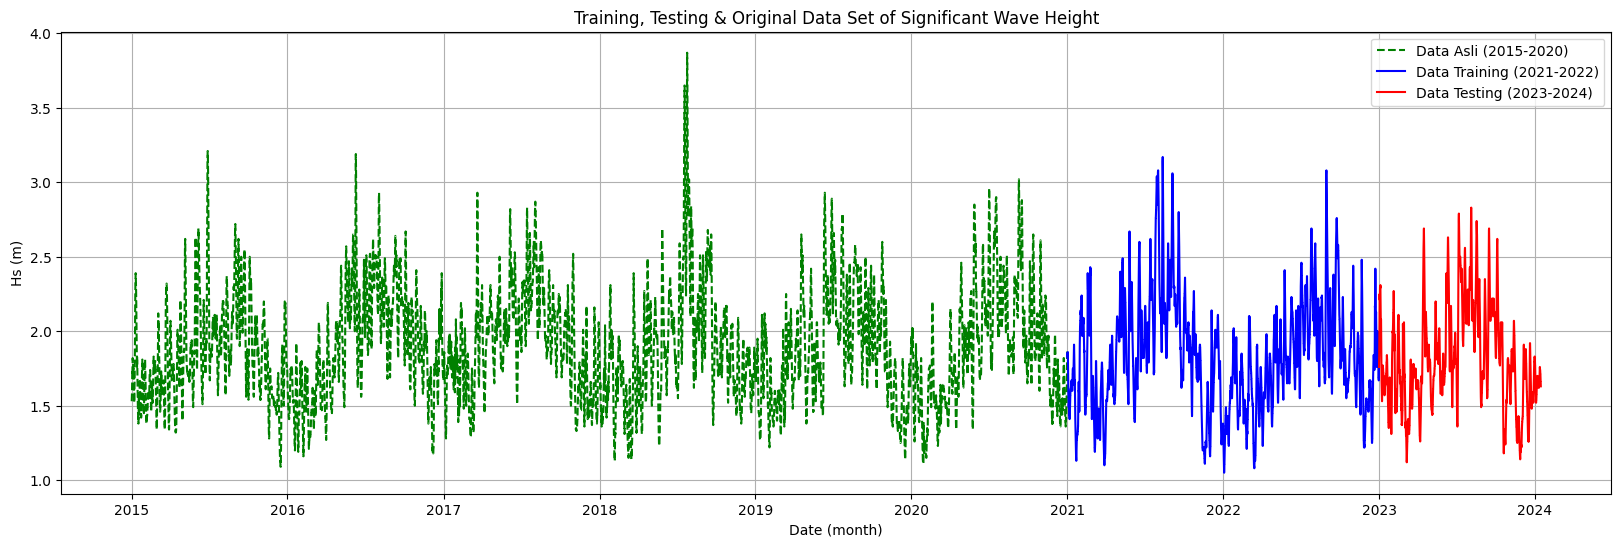

In [7]:
# Pastikan data terurut berdasarkan indeks waktu
data_with_lags = data_with_lags.sort_index()

# Membagi data berdasarkan rentang waktu
# Data asli 2015-2020
X_original = data_with_lags.loc['2015-01-01':'2020-12-31'].drop(columns=['Wave_Height'])
y_original = data_with_lags.loc['2015-01-01':'2020-12-31', 'Wave_Height']

# Data training 2021-2022
X_train_lag_2_years = data_with_lags.loc['2021-01-01':'2022-12-31'].drop(columns=['Wave_Height'])
y_train_lag_2_years = data_with_lags.loc['2021-01-01':'2022-12-31', 'Wave_Height']

# Data testing 2023-2024
X_test_lag_1_year = data_with_lags.loc['2023-01-01':'2024-01-15'].drop(columns=['Wave_Height'])
y_test_lag_1_year = data_with_lags.loc['2023-01-01':'2024-01-15', 'Wave_Height']

# Cek apakah ada missing values di data asli, training, dan testing
print("Missing values in original data (2015-2020):")
print(X_original.isnull().sum())  # Untuk fitur asli
print("Missing values in original target (2015-2020):")
print(y_original.isnull().sum())  # Untuk target asli

print("Missing values in training features (2021-2022):")
print(X_train_lag_2_years.isnull().sum())  # Untuk fitur training
print("Missing values in training target (2021-2022):")
print(y_train_lag_2_years.isnull().sum())  # Untuk target training

print("Missing values in testing features (2023-2024):")
print(X_test_lag_1_year.isnull().sum())  # Untuk fitur testing
print("Missing values in testing target (2023-2024):")
print(y_test_lag_1_year.isnull().sum())  # Untuk target testing

# Jika ada missing values, kita interpolasi
X_original = X_original.interpolate(method='linear')
y_original = y_original.interpolate(method='linear')

X_train_lag_2_years = X_train_lag_2_years.interpolate(method='linear')
y_train_lag_2_years = y_train_lag_2_years.interpolate(method='linear')

X_test_lag_1_year = X_test_lag_1_year.interpolate(method='linear')
y_test_lag_1_year = y_test_lag_1_year.interpolate(method='linear')

# Plot data asli (2015-2020), training (2021-2022), dan testing (2023-2024)
plt.figure(figsize=(20,6))

# Plot data asli (2015-2020)
plt.plot(X_original.index, y_original, label='Data Asli (2015-2020)', color='green', linestyle='--')

# Plot data training (2021-2022)
plt.plot(X_train_lag_2_years.index, y_train_lag_2_years, label='Data Training (2021-2022)', color='blue')

# Plot data testing (2023-2024)
plt.plot(X_test_lag_1_year.index, y_test_lag_1_year, label='Data Testing (2023-2024)', color='red')

# Judul dan label
plt.title('Training, Testing & Original Data Set of Significant Wave Height')
plt.xlabel('Date (month)')
plt.ylabel('Hs (m)')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()


In [8]:
# Membuat model CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, cat_features=[], verbose=200)

# Latih model dengan data training (2021-2022)
model.fit(X_train_lag_2_years, y_train_lag_2_years)

# Prediksi dengan data testing (2023-2024)
y_pred = model.predict(X_test_lag_1_year)

# Menghitung RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_lag_1_year, y_pred))

# Menghitung MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_lag_1_year - y_pred) / y_test_lag_1_year)) * 100

# Menghitung CC (Correlation Coefficient) menggunakan Pearson
cc, _ = pearsonr(y_test_lag_1_year, y_pred)

# Menghitung R^2 (Coefficient of Determination)
r2 = r2_score(y_test_lag_1_year, y_pred)

# Menampilkan hasil evaluasi
print(f"RMSE: {rmse}")
print(f"CC: {cc}")
print(f"R^2: {r2}")


0:	learn: 0.3397379	total: 18.2ms	remaining: 18.2s
200:	learn: 0.0128955	total: 1.15s	remaining: 4.57s
400:	learn: 0.0085548	total: 2.26s	remaining: 3.37s
600:	learn: 0.0069949	total: 3.92s	remaining: 2.6s
800:	learn: 0.0062692	total: 5.09s	remaining: 1.26s
999:	learn: 0.0058812	total: 6.36s	remaining: 0us
RMSE: 0.007673355342660126
CC: 0.9997458545632742
R^2: 0.9994910438294199


Missing values in original data (2015-2018):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in original target (2015-2018):
0
Missing values in training features (2019-2022):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in training target (2019-2022):
0
Missing values in testing features (2023-2024):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in testing target (2023-2024):
0


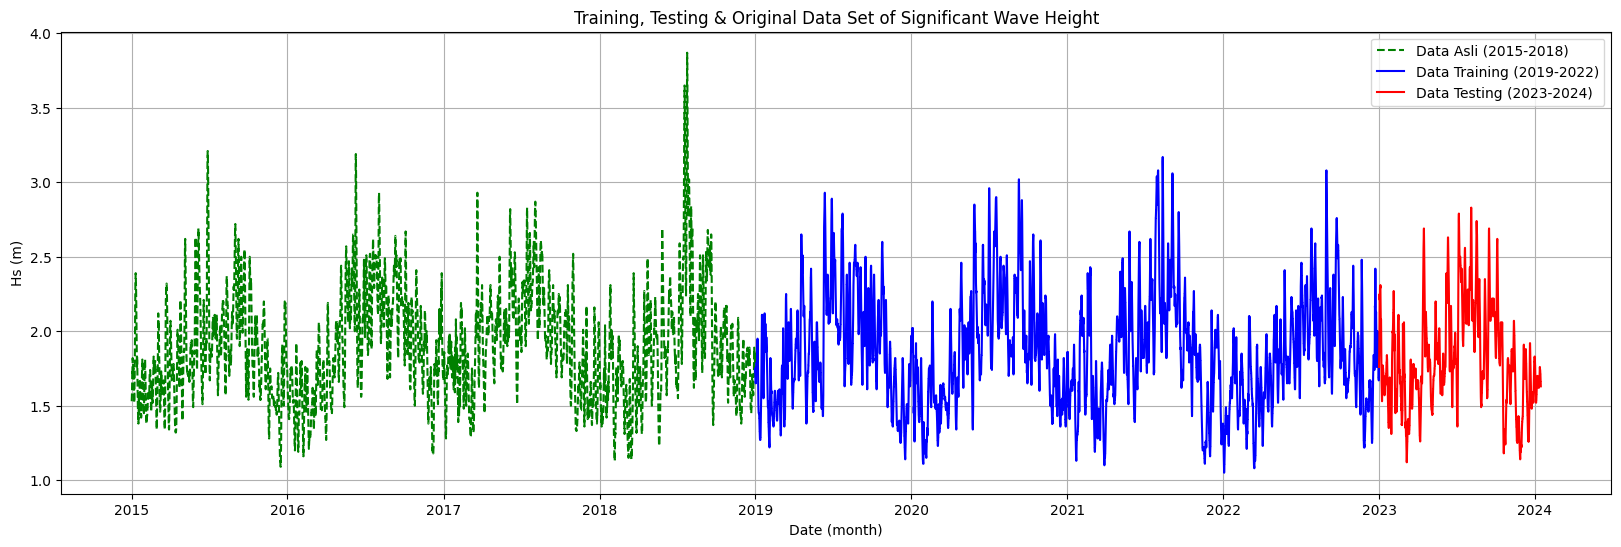

In [9]:
# Pastikan data terurut berdasarkan indeks waktu
data_with_lags = data_with_lags.sort_index()

# Membagi data berdasarkan rentang waktu
# Data asli 2015-2018
X_original = data_with_lags.loc['2015-01-01':'2018-12-31'].drop(columns=['Wave_Height'])
y_original = data_with_lags.loc['2015-01-01':'2018-12-31', 'Wave_Height']

# Data training 2019-2022
X_train_lag_4_years = data_with_lags.loc['2019-01-01':'2022-12-31'].drop(columns=['Wave_Height'])
y_train_lag_4_years = data_with_lags.loc['2019-01-01':'2022-12-31', 'Wave_Height']

# Data testing 2023-2024
X_test_lag_1_year = data_with_lags.loc['2023-01-01':'2024-01-15'].drop(columns=['Wave_Height'])
y_test_lag_1_year = data_with_lags.loc['2023-01-01':'2024-01-15', 'Wave_Height']

# Cek apakah ada missing values di data asli, training, dan testing
print("Missing values in original data (2015-2018):")
print(X_original.isnull().sum())  # Untuk fitur asli
print("Missing values in original target (2015-2018):")
print(y_original.isnull().sum())  # Untuk target asli

print("Missing values in training features (2019-2022):")
print(X_train_lag_4_years.isnull().sum())  # Untuk fitur training
print("Missing values in training target (2019-2022):")
print(y_train_lag_4_years.isnull().sum())  # Untuk target training

print("Missing values in testing features (2023-2024):")
print(X_test_lag_1_year.isnull().sum())  # Untuk fitur testing
print("Missing values in testing target (2023-2024):")
print(y_test_lag_1_year.isnull().sum())  # Untuk target testing

# Jika ada missing values, kita interpolasi
X_original = X_original.interpolate(method='linear')
y_original = y_original.interpolate(method='linear')

X_train_lag_4_years = X_train_lag_4_years.interpolate(method='linear')
y_train_lag_4_years = y_train_lag_4_years.interpolate(method='linear')

X_test_lag_1_year = X_test_lag_1_year.interpolate(method='linear')
y_test_lag_1_year = y_test_lag_1_year.interpolate(method='linear')

# Plot data asli (2015-2018), training (2019-2022), dan testing (2023-2024)
plt.figure(figsize=(20,6))

# Plot data asli (2015-2018)
plt.plot(X_original.index, y_original, label='Data Asli (2015-2018)', color='green', linestyle='--')

# Plot data training (2019-2022)
plt.plot(X_train_lag_4_years.index, y_train_lag_4_years, label='Data Training (2019-2022)', color='blue')

# Plot data testing (2023-2024)
plt.plot(X_test_lag_1_year.index, y_test_lag_1_year, label='Data Testing (2023-2024)', color='red')

# Judul dan label
plt.title('Training, Testing & Original Data Set of Significant Wave Height')
plt.xlabel('Date (month)')
plt.ylabel('Hs (m)')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()


In [10]:
# Membuat model CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, cat_features=[], verbose=200)

# Latih model dengan data training (2019-2022)
model.fit(X_train_lag_4_years, y_train_lag_4_years)

# Prediksi dengan data testing (2023-2024)
y_pred = model.predict(X_test_lag_1_year)

# Menghitung RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_lag_1_year, y_pred))

# Menghitung R² (koefisien determinasi)
r2 = r2_score(y_test_lag_1_year, y_pred)

# Menghitung CC (Correlation Coefficient) menggunakan Pearson
cc, _ = pearsonr(y_test_lag_1_year, y_pred)

# Menampilkan hasil evaluasi
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"CC: {cc:.4f}")


0:	learn: 0.3404916	total: 12.3ms	remaining: 12.3s
200:	learn: 0.0122363	total: 2.03s	remaining: 8.08s
400:	learn: 0.0083618	total: 3.76s	remaining: 5.61s
600:	learn: 0.0070148	total: 5.39s	remaining: 3.58s
800:	learn: 0.0064350	total: 7.32s	remaining: 1.82s
999:	learn: 0.0061322	total: 9.16s	remaining: 0us
RMSE: 0.0069
R²: 0.9996
CC: 0.9998


Missing values in training features (2015-2022):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in training target (2015-2022):
0
Missing values in testing features (2023-2024):
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
Second               0
Wave_Height_lag_1    0
Wave_Height_lag_2    0
Wave_Height_lag_3    0
dtype: int64
Missing values in testing target (2023-2024):
0


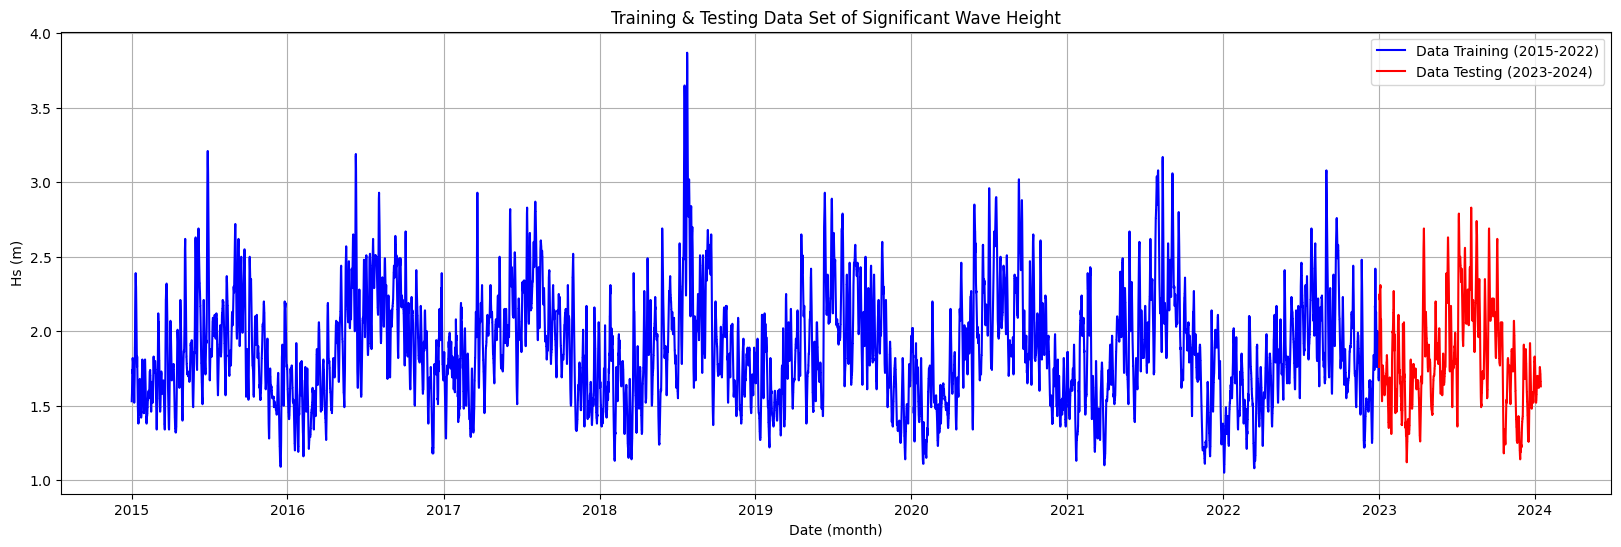

In [11]:
# Pastikan data terurut berdasarkan indeks waktu
data_with_lags = data_with_lags.sort_index()

# Membagi data berdasarkan rentang waktu
# Data training 2015-2022
X_train_lag_7_years = data_with_lags.loc['2015-01-01':'2022-12-31'].drop(columns=['Wave_Height'])
y_train_lag_7_years = data_with_lags.loc['2015-01-01':'2022-12-31', 'Wave_Height']

# Data testing 2023-2024
X_test_lag_1_year = data_with_lags.loc['2023-01-01':'2024-01-15'].drop(columns=['Wave_Height'])
y_test_lag_1_year = data_with_lags.loc['2023-01-01':'2024-01-15', 'Wave_Height']

# Cek apakah ada missing values di data training dan testing
print("Missing values in training features (2015-2022):")
print(X_train_lag_7_years.isnull().sum())  # Untuk fitur training
print("Missing values in training target (2015-2022):")
print(y_train_lag_7_years.isnull().sum())  # Untuk target training

print("Missing values in testing features (2023-2024):")
print(X_test_lag_1_year.isnull().sum())  # Untuk fitur testing
print("Missing values in testing target (2023-2024):")
print(y_test_lag_1_year.isnull().sum())  # Untuk target testing

# Jika ada missing values, kita interpolasi
X_train_lag_7_years = X_train_lag_7_years.interpolate(method='linear')
y_train_lag_7_years = y_train_lag_7_years.interpolate(method='linear')

X_test_lag_1_year = X_test_lag_1_year.interpolate(method='linear')
y_test_lag_1_year = y_test_lag_1_year.interpolate(method='linear')

# Plot data training (2015-2022) dan testing (2023-2024)
plt.figure(figsize=(20,6))

# Plot data training (2015-2022)
plt.plot(X_train_lag_7_years.index, y_train_lag_7_years, label='Data Training (2015-2022)', color='blue')

# Plot data testing (2023-2024)
plt.plot(X_test_lag_1_year.index, y_test_lag_1_year, label='Data Testing (2023-2024)', color='red')

# Judul dan label
plt.title('Training & Testing Data Set of Significant Wave Height')
plt.xlabel('Date (month)')
plt.ylabel('Hs (m)')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()


In [12]:
# Membuat model CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, cat_features=[], verbose=200)

# Latih model dengan data training (2015-2022)
model.fit(X_train_lag_7_years, y_train_lag_7_years)

# Prediksi dengan data testing (2023-2024)
y_pred = model.predict(X_test_lag_1_year)

# Menghitung RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_lag_1_year, y_pred))

# Menghitung R² (koefisien determinasi)
r2 = r2_score(y_test_lag_1_year, y_pred)

# Menghitung CC (Correlation Coefficient) menggunakan Pearson
cc, _ = pearsonr(y_test_lag_1_year, y_pred)

# Menampilkan hasil evaluasi
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"CC: {cc:.4f}")


0:	learn: 0.3354202	total: 12.7ms	remaining: 12.7s
200:	learn: 0.0120738	total: 2.58s	remaining: 10.2s
400:	learn: 0.0084457	total: 5.2s	remaining: 7.77s
600:	learn: 0.0072020	total: 7.61s	remaining: 5.05s
800:	learn: 0.0066440	total: 10.5s	remaining: 2.6s
999:	learn: 0.0063798	total: 13.2s	remaining: 0us
RMSE: 0.0066
R²: 0.9996
CC: 0.9998


In [13]:
# Function to reverse normalization and calculate metrics
def evaluate_predictions(testY, testPredict, scaler, num_steps):
    # Reverse normalization
    testY_actual = scaler.inverse_transform(testY[:num_steps].reshape(-1, 1))
    testPredict_actual = scaler.inverse_transform(testPredict[:num_steps])

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(testY_actual, testPredict_actual))
    r2 = r2_score(testY_actual, testPredict_actual)


    return rmse, r2

In [14]:
# Fungsi untuk menghitung RMSE kumulatif
def calculate_cumulative_rmse(actual, predicted):
    cumulative_rmse = []
    cumulative_error = 0
    for i in range(1, len(actual) + 1):
        cumulative_error += mean_squared_error(actual[:i], predicted[:i])
        cumulative_rmse.append(np.sqrt(cumulative_error / i))  # Hitung RMSE untuk semua langkah hingga i
    return cumulative_rmse

In [15]:
# Fungsi untuk menghitung MAPE
def MAPE(x, y):
    result = 0
    for i in range(len(x)):
        result += abs((x[i] - y[i]) / x[i])
    result /= len(x)
    result *= 100
    return result
    

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Definisi jumlah langkah prediksi
num_steps = 16  # Sesuaikan dengan resolusi data Anda (misalnya, 16 data untuk 16 jam)

# Contoh data
# Ganti dengan data Anda sendiri
X_test_16_steps = X_test_lag_1_year.iloc[:num_steps]  # Data fitur untuk prediksi (16 langkah pertama)
testPredict_16_steps = model.predict(X_test_16_steps)  # Hasil prediksi dari model
testY_actual_16_steps = y_test_lag_1_year.iloc[:num_steps].values  # Data aktual target

# Fungsi untuk menghitung RMSE kumulatif
def calculate_cumulative_rmse(actual, predicted):
    cumulative_error = 0
    for i in range(1, len(actual) + 1):
        cumulative_error += mean_squared_error(actual[:i], predicted[:i])
    return np.sqrt(cumulative_error / len(actual))  # RMSE kumulatif

# Fungsi untuk menghitung MAPE
def calculate_mape(actual, predicted):
    # Pastikan tidak ada pembagian dengan nol
    actual = np.where(actual == 0, np.finfo(float).eps, actual)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Hitung metrik evaluasi
rmse_cumulative_16_steps = calculate_cumulative_rmse(testY_actual_16_steps, testPredict_16_steps)  # RMSE kumulatif
rmse_16_steps = np.sqrt(mean_squared_error(testY_actual_16_steps, testPredict_16_steps))  # RMSE
mape_16_steps = calculate_mape(testY_actual_16_steps, testPredict_16_steps)  # MAPE
r2_16_steps = r2_score(testY_actual_16_steps, testPredict_16_steps)  # R²

# Menampilkan hasil evaluasi
print(f'R^2 Score (16 steps): {r2_16_steps:.4f}')
print(f'RMSE for first {num_steps} predictions: {rmse_16_steps:.4f}')
print(f'MAPE (16 steps): {mape_16_steps:.4f}%')
print(f'Cumulative RMSE (16 steps): {rmse_cumulative_16_steps:.4f}')


R^2 Score (16 steps): 0.9644
RMSE for first 16 predictions: 0.0162
MAPE (16 steps): 0.7068%
Cumulative RMSE (16 steps): 0.0141


In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Fungsi untuk menghitung RMSE kumulatif
def calculate_cumulative_rmse(actual, predicted):
    cumulative_error = 0
    for i in range(1, len(actual) + 1):
        cumulative_error += mean_squared_error(actual[:i], predicted[:i])
    return np.sqrt(cumulative_error / len(actual))  # RMSE kumulatif

# Fungsi untuk menghitung MAPE (tanpa persentase)
def calculate_mape(actual, predicted):
    # Pastikan tidak ada pembagian dengan nol
    actual = np.where(actual == 0, np.finfo(float).eps, actual)
    return np.mean(np.abs((actual - predicted) / actual))

# Definisi jumlah langkah prediksi (48, 80, 112, dan 224 hari)
time_steps = [16, 48, 80, 112, 224]  # Daftar jumlah langkah waktu

# Iterasi untuk setiap jumlah langkah waktu
for num_steps in time_steps:
    # Data untuk prediksi (ganti dengan data aktual Anda)
    X_test_steps = X_test_lag_1_year.iloc[:num_steps]  # Data fitur untuk prediksi
    testPredict_steps = model.predict(X_test_steps)  # Hasil prediksi dari model
    testY_actual_steps = y_test_lag_1_year.iloc[:num_steps].values  # Data aktual target

    # Hitung metrik evaluasi
    rmse_cumulative = calculate_cumulative_rmse(testY_actual_steps, testPredict_steps)  # RMSE kumulatif
    rmse = np.sqrt(mean_squared_error(testY_actual_steps, testPredict_steps))  # RMSE
    mape = calculate_mape(testY_actual_steps, testPredict_steps)  # MAPE
    r2 = r2_score(testY_actual_steps, testPredict_steps)  # R²

    # Menampilkan hasil evaluasi
    print(f'Evaluation for {num_steps} days:')
    print(f'  R^2 Score: {r2:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  MAPE: {mape:.4f}')  # Tidak ada simbol persen
    print(f'  Cumulative RMSE: {rmse_cumulative:.4f}')
    print('-----------------------------------')


Evaluation for 16 days:
  R^2 Score: 0.9644
  RMSE: 0.0162
  MAPE: 0.0071
  Cumulative RMSE: 0.0141
-----------------------------------
Evaluation for 48 days:
  R^2 Score: 0.9933
  RMSE: 0.0151
  MAPE: 0.0058
  Cumulative RMSE: 0.0156
-----------------------------------
Evaluation for 80 days:
  R^2 Score: 0.9932
  RMSE: 0.0128
  MAPE: 0.0047
  Cumulative RMSE: 0.0149
-----------------------------------
Evaluation for 112 days:
  R^2 Score: 0.9978
  RMSE: 0.0116
  MAPE: 0.0044
  Cumulative RMSE: 0.0142
-----------------------------------
Evaluation for 224 days:
  R^2 Score: 0.9985
  RMSE: 0.0095
  MAPE: 0.0038
  Cumulative RMSE: 0.0124
-----------------------------------


In [18]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Langkah 1: Tentukan parameter untuk tuning, termasuk l2_leaf_reg
param_grid = {
    'iterations': [500, 750, 1000],  # Jumlah iterasi
    'learning_rate': [0.2, 0.1, 0.001, 0.0001, 0.00001],  # Tingkat pembelajaran
    'depth': [4, 6, 8],  # Kedalaman pohon
    'l2_leaf_reg': [3, 5, 10],  # Regularisasi L2
}

# Langkah 2: Membuat model CatBoost dengan early stopping
catboost = CatBoostRegressor(loss_function='RMSE', verbose=0, random_state=42, early_stopping_rounds=50)

# Langkah 3: Menggunakan TimeSeriesSplit untuk validasi yang sesuai dengan data time series
tscv = TimeSeriesSplit(n_splits=5)

# Langkah 4: Menggunakan GridSearchCV untuk tuning hyperparameter
grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Langkah 5: Melatih model dengan data training
grid_search.fit(X_train_lag_7_years, y_train_lag_7_years)

# Langkah 6: Menyimpan model terbaik
best_model = grid_search.best_estimator_

# Langkah 7: Menampilkan parameter terbaik
print(f'Best Hyperparameters: {grid_search.best_params_}')

# Langkah 8: Melakukan prediksi pada data testing dengan model terbaik
y_pred_best = best_model.predict(X_test_lag_1_year)

# Langkah 9: Menghitung Root Mean Squared Error (RMSE)
rmse_best = np.sqrt(mean_squared_error(y_test_lag_1_year, y_pred_best))
print(f'Root Mean Squared Error (RMSE) with Best Hyperparameters: {rmse_best}')

# Langkah 10: Menghitung Coefficient of Correlation (CC)
cc = np.corrcoef(y_test_lag_1_year, y_pred_best)[0, 1]
print(f'Coefficient of Correlation (CC): {cc}')

# Langkah 11: Menghitung R² (Koefisien Determinasi)
r2 = r2_score(y_test_lag_1_year, y_pred_best)
print(f'R² (Coefficient of Determination): {r2}')


c:\Users\osana\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.2}
Root Mean Squared Error (RMSE) with Best Hyperparameters: 0.00645098145975334
Coefficient of Correlation (CC): 0.999820129660344
R² (Coefficient of Determination): 0.9996402826784048


In [19]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Fungsi untuk menghitung RMSE kumulatif
def calculate_cumulative_rmse(actual, predicted):
    cumulative_error = 0
    for i in range(1, len(actual) + 1):
        cumulative_error += mean_squared_error(actual[:i], predicted[:i])
    return np.sqrt(cumulative_error / len(actual))  # RMSE kumulatif

# Fungsi untuk menghitung MAPE
def calculate_mape(actual, predicted):
    # Pastikan tidak ada pembagian dengan nol
    actual = np.where(actual == 0, np.finfo(float).eps, actual)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Jumlah data pertama yang akan diprediksi
num_steps_16 = 16  

# Data untuk prediksi dan aktual
X_test_steps_16 = X_test_lag_1_year.iloc[:num_steps_16]  # Data fitur untuk 16 langkah
testPredict_16 = best_model.predict(X_test_steps_16)  # Prediksi dengan model terbaik
testY_actual_16 = y_test_lag_1_year.iloc[:num_steps_16].values  # Data aktual target

# Hitung metrik evaluasi
rmse_cumulative_16 = calculate_cumulative_rmse(testY_actual_16, testPredict_16)  # RMSE kumulatif
rmse_16 = np.sqrt(mean_squared_error(testY_actual_16, testPredict_16))  # RMSE
mape_16 = calculate_mape(testY_actual_16, testPredict_16)  # MAPE
r2_16 = r2_score(testY_actual_16, testPredict_16)  # R²

# Menampilkan hasil evaluasi
print(f'Evaluation for first {num_steps_16} steps:')
print(f'  R^2 Score: {r2_16:.4f}')
print(f'  RMSE: {rmse_16:.4f}')
print(f'  MAPE: {mape_16:.4f}%')
print(f'  Cumulative RMSE: {rmse_cumulative_16:.4f}')
print('-----------------------------------')


Evaluation for first 16 steps:
  R^2 Score: 0.9638
  RMSE: 0.0163
  MAPE: 0.6936%
  Cumulative RMSE: 0.0138
-----------------------------------


In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Fungsi untuk menghitung RMSE kumulatif
def calculate_cumulative_rmse(actual, predicted):
    cumulative_error = 0
    for i in range(1, len(actual) + 1):
        cumulative_error += mean_squared_error(actual[:i], predicted[:i])
    return np.sqrt(cumulative_error / len(actual))  # RMSE kumulatif

# Fungsi untuk menghitung MAPE tanpa tanda persen
def calculate_mape(actual, predicted):
    # Pastikan tidak ada pembagian dengan nol
    actual = np.where(actual == 0, np.finfo(float).eps, actual)
    return np.mean(np.abs((actual - predicted) / actual))  # Hilangkan * 100

# Daftar jumlah langkah prediksi
time_steps = [16, 48, 80, 112, 224]

# Iterasi untuk setiap jumlah langkah waktu
for num_steps in time_steps:
    # Data untuk prediksi
    X_test_steps = X_test_lag_1_year.iloc[:num_steps]  # Data fitur untuk prediksi
    testPredict_steps = best_model.predict(X_test_steps)  # Prediksi dengan model terbaik
    testY_actual_steps = y_test_lag_1_year.iloc[:num_steps].values  # Data aktual target

    # Hitung metrik evaluasi
    rmse_cumulative = calculate_cumulative_rmse(testY_actual_steps, testPredict_steps)  # RMSE kumulatif
    rmse = np.sqrt(mean_squared_error(testY_actual_steps, testPredict_steps))  # RMSE
    mape = calculate_mape(testY_actual_steps, testPredict_steps)  # MAPE tanpa tanda persen
    r2 = r2_score(testY_actual_steps, testPredict_steps)  # R²

    # Menampilkan hasil evaluasi
    print(f'Evaluation for first {num_steps} steps:')
    print(f'  R^2 Score: {r2:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  MAPE: {mape:.4f}')
    print(f'  Cumulative RMSE: {rmse_cumulative:.4f}')
    print('-----------------------------------')


Evaluation for first 16 steps:
  R^2 Score: 0.9638
  RMSE: 0.0163
  MAPE: 0.0069
  Cumulative RMSE: 0.0138
-----------------------------------
Evaluation for first 48 steps:
  R^2 Score: 0.9934
  RMSE: 0.0150
  MAPE: 0.0056
  Cumulative RMSE: 0.0157
-----------------------------------
Evaluation for first 80 steps:
  R^2 Score: 0.9934
  RMSE: 0.0127
  MAPE: 0.0045
  Cumulative RMSE: 0.0149
-----------------------------------
Evaluation for first 112 steps:
  R^2 Score: 0.9979
  RMSE: 0.0112
  MAPE: 0.0040
  Cumulative RMSE: 0.0141
-----------------------------------
Evaluation for first 224 steps:
  R^2 Score: 0.9986
  RMSE: 0.0092
  MAPE: 0.0036
  Cumulative RMSE: 0.0121
-----------------------------------


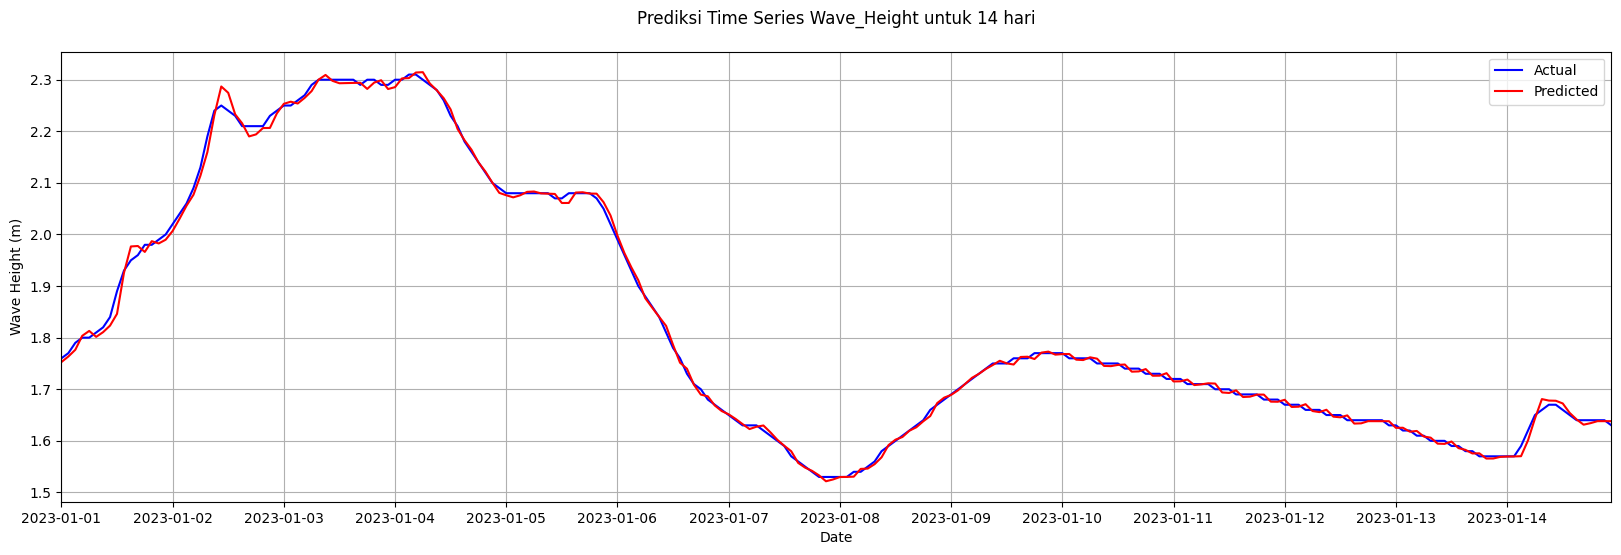

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Definisikan num_steps sebagai 224
num_steps = 224  

# Data untuk 224 langkah pertama
testY_actual_224 = y_test_lag_1_year.iloc[:num_steps].values  # Data aktual target
testPredict_224 = best_model.predict(X_test_lag_1_year.iloc[:num_steps])  # Prediksi dengan model terbaik

# Visualisasi prediksi vs data aktual
plt.figure(figsize=(20, 6))

# Plot data aktual dan prediksi
plt.plot(y_test_lag_1_year.index[:num_steps], testY_actual_224, label='Actual', color='blue')  
plt.plot(y_test_lag_1_year.index[:num_steps], testPredict_224, label='Predicted', color='red')  

# Menambahkan judul, label, dan legenda
plt.title(f'Prediksi Time Series Wave_Height untuk 14 hari', pad=20)  # Atur jarak judul dengan plot
plt.xlabel('Date')
plt.ylabel('Wave Height (m)')
plt.legend()

# Format tanggal pada sumbu x dengan interval harian
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Mengatur interval harian
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format tanggal

# Mengatur agar garis menempel pada sisi kiri dan kanan tetapi tidak di bagian atas
plt.margins(x=0)  # Margin horizontal 0, margin vertikal 0 untuk plot area
plt.subplots_adjust(top=0.9, bottom=0.15)  # Menambahkan spasi margin atas dan bawah

# Tampilkan grid
plt.grid(True)
plt.show()